# Емельянова Елизавета Всеволодовна БВТ2201

# Лабаораторная работа №2: Классификация аудио

In [1]:
!pip install torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.5 MB/s eta 0:00:00


In [3]:
!pip -q install datasets torchaudio torch torchvision scikit-learn transformers accelerate --upgrade

In [4]:
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000

Device: cuda


In [6]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR))

def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00016-e478d7cccca6a0(…):   0%|          | 0.00/434M [00:00<?, ?B/s]

data/train-00001-of-00016-299138aa39afaa(…):   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00002-of-00016-887e0748205b6f(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

data/train-00003-of-00016-691ee48aa53d9c(…):   0%|          | 0.00/447M [00:00<?, ?B/s]

data/train-00004-of-00016-c0f37514d8e28a(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00005-of-00016-55ef1a0a51149c(…):   0%|          | 0.00/591M [00:00<?, ?B/s]

data/train-00006-of-00016-0ef363072505e6(…):   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00007-of-00016-dfac173beb21e5(…):   0%|          | 0.00/588M [00:00<?, ?B/s]

data/train-00008-of-00016-2744487f32f65d(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00009-of-00016-83fc7364d47981(…):   0%|          | 0.00/549M [00:00<?, ?B/s]

data/train-00010-of-00016-4c1d0e285ed778(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00011-of-00016-79d186503a2667(…):   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00012-of-00016-6aff88fdcca229(…):   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00013-of-00016-17d827b1a5be04(…):   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00014-of-00016-c630762df85f6c(…):   0%|          | 0.00/381M [00:00<?, ?B/s]

data/train-00015-of-00016-03506887d89adf(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

(7079, 816, 837, 10)

In [7]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])    # создается конвеер для обработки данных и обучения классификатора
clf.fit(X_tr, y_tr)   # классификатор обучается на тренировочных обработанных данных
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))   # точность на валидационной выборке
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))  # точность на тестовой выборке


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


In [23]:
class RawWaveDS(Dataset):   # подготовка датасета
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):     # приведение всех аудиоданных батча к одной длине
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):   # класс для трансформера
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)  # оптимизатор для обновления параметров модели во время обучения
crit = nn.CrossEntropyLoss()                          # функция потерь для оценки качества предсказаний модели во время обучения

history = {
    "tr_loss": [],
    "tr_acc": [],
    "va_loss": [],
    "va_acc": []
}

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    all_preds = []
    all_labels = []

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()   # вычисляем градиенты и обновляем веса модели
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1); correct += (pred==yb).sum().item(); total += xb.size(0)  # получение индексов классов с наивысшими вероятностями для каждого примера

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

    loss_avg = loss_sum/total
    accuracy = correct/total
    return loss_avg, accuracy, all_preds, all_labels

total_correct = 0
total_examples = 0
all_preds_valid = []
all_labels_valid = []

epochs = 2
for ep in range(1, epochs + 1):
    tr_l, tr_a, tr_preds, tr_labels = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, va_preds, va_labels = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    total_correct += va_a * len(val_loader.dataset)
    total_examples += len(val_loader.dataset)

    all_preds_valid.extend(va_preds)
    all_labels_valid.extend(va_labels)

    history["tr_loss"].append(tr_l)
    history["tr_acc"].append(tr_a)
    history["va_loss"].append(va_l)
    history["va_acc"].append(va_a)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

# Тест
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()
print("CNN TEST acc:", accuracy_score(y_true, y_pred))


Ep 01: train 1.4193/0.494 | valid 1.0893/0.641


Ep 02: train 0.9792/0.661 | valid 1.3365/0.587


CNN TEST acc: 0.5244922341696535


In [10]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [11]:
MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b:
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()
print("AST VALID:", trainer.evaluate(va_ast))
print("AST TEST :", trainer.evaluate(te_ast))


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.240900,0.892066,0.834559,0.850154
2,0.143200,0.854748,0.868873,0.881266
3,0.058200,0.830718,0.888480,0.903544
4,0.039600,1.262304,0.849265,0.865496
5,0.047600,1.196425,0.848039,0.855511
6,0.024400,0.876501,0.890931,0.905896
7,0.006400,1.137867,0.868873,0.879906
8,0.002200,1.207048,0.881127,0.893437
9,0.005100,0.996378,0.898284,0.911014
10,0.000000,1.050252,0.894608,0.907422


AST VALID: {'eval_loss': 1.0502519607543945, 'eval_accuracy': 0.8946078431372549, 'eval_f1_macro': 0.9074220689756753, 'eval_runtime': 39.4885, 'eval_samples_per_second': 20.664, 'eval_steps_per_second': 2.583, 'epoch': 10.0}
AST TEST : {'eval_loss': 1.001033902168274, 'eval_accuracy': 0.8888888888888888, 'eval_f1_macro': 0.9006174466223115, 'eval_runtime': 41.2019, 'eval_samples_per_second': 20.315, 'eval_steps_per_second': 2.548, 'epoch': 10.0}


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [24]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST
import pandas as pd

overall_accuracy = total_correct / total_examples
f1 = f1_score(all_labels_valid, all_preds_valid, average='macro')

test_acc = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='macro')

cnn_val_acc  = overall_accuracy
cnn_val_f1   = f1
cnn_test_acc = test_acc
cnn_test_f1  = test_f1

valid_results = trainer.evaluate(va_ast)
test_results = trainer.evaluate(te_ast)

ast_val_acc  = valid_results['eval_accuracy']
ast_val_f1   = valid_results['eval_f1_macro']
ast_test_acc = test_results['eval_accuracy']
ast_test_f1  = test_results['eval_f1_macro']

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results


,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.613971,0.597576,0.524492,0.488991
1,AST FT,0.894608,0.907422,0.888889,0.900617


In [25]:
print(history)

{'tr_loss': [1.4193191641989291, 0.9792284850835766], 'tr_acc': [0.49357253849413757, 0.6605452747563215], 'va_loss': [1.0893349567172574, 1.3364780597827013], 'va_acc': [0.6409313725490197, 0.5870098039215687]}


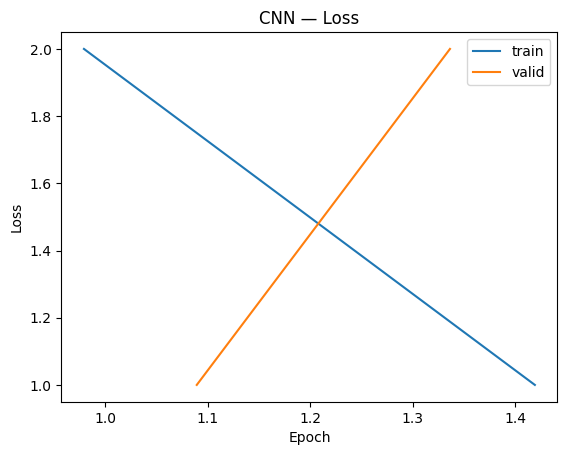

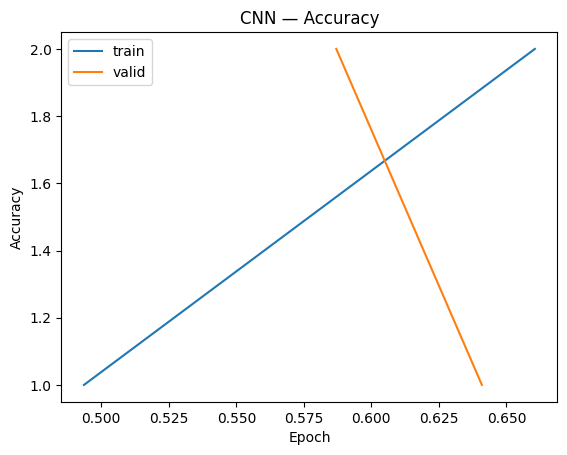

In [26]:
# TODO(1.2): Графики обучения CNN (loss/acc по эпохам)

import matplotlib.pyplot as plt

epochs_num = [i + 1 for i, x in enumerate(history['tr_loss']) if x]

plt.figure()
plt.plot(history["tr_loss"], epochs_num, label="train_loss")
plt.plot(history["va_loss"], epochs_num, label="valid_loss");
plt.title("CNN — Loss")
plt.legend(["train","valid"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(history["tr_acc"], epochs_num, label="train_accuracy")
plt.plot(history["va_acc"], epochs_num, label="valid_accuracy")
plt.title("CNN — Accuracy")
plt.legend(["train","valid"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


## Задание 2. Эксперимент (выберите один вариант)

**Вариант A:** добавить SpecAugment в обучение CNN.  
**Вариант B:** изменить параметры мел-спектрограмм (например, `N_MELS`, `HOP`, `N_FFT`) и переобучить CNN.

Оформите гипотезу → что меняете → метрики ДО/ПОСЛЕ → краткий вывод.


In [ ]:
# TODO(2.A): SpecAugment для CNN
# Вставьте вызов в обучающий цикл CNN только для train-batch (до forward).
# Подпишите конфигурацию масок.

import numpy as np
import torch

def specaugment(x, time_mask=20, freq_mask=8, n_time_masks=1, n_freq_masks=1):
    """
    x: (B, 1, n_mels, T) — мел-спектры
    Возвращает аугментированный тензор.
    """
    # TODO: реализовать маскирование по времени и по частоте (n_time_masks / n_freq_masks)
    # Подсказка: зануляйте x[:, :, f0:f0+f, :] и x[:, :, :, t0:t0+t]
    return x

# Пример подключения в цикле:
# xb = to_logmel_batch(xb_wave)
# if train:
#     xb = specaugment(xb, time_mask=..., freq_mask=...)
# logits = model(xb)


In [29]:
# TODO(2.B): Изменение мел-параметров для CNN

N_MELS_NEW = 128   # было 64
HOP_NEW    = 128  # было 256
N_FFT_NEW  = 1024 # по необходимости

# 1) Пересоздайте MelSpectrogram/AmplitudeToDB с новыми параметрами

mel_gpu_new = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT_NEW, hop_length=HOP_NEW,
                           n_mels=N_MELS_NEW, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu_new = T.AmplitudeToDB(top_db=80).to(device)

# 2) Обновите функцию to_logmel_batch (если параметры зашиты)

FIX_T = 128
def to_logmel_batch_new(xb_1d):
    S = to_db_gpu_new(mel_gpu_new(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

# 3) Переобучите CNN и посчитаете метрики (VAL/TEST)

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0

    all_preds = []
    all_labels = []

    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()   # вычисляем градиенты и обновляем веса модели
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1); correct += (pred==yb).sum().item(); total += xb.size(0)  # получение индексов классов с наивысшими вероятностями для каждого примера

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

    loss_avg = loss_sum/total
    accuracy = correct/total
    return loss_avg, accuracy, all_preds, all_labels

total_correct_new = 0
total_examples_new = 0
all_preds_valid_new = []
all_labels_valid_new = []

epochs = 2
for ep in range(1, epochs + 1):
    tr_l, tr_a, tr_preds, tr_labels = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, va_preds, va_labels = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    total_correct_new += va_a * len(val_loader.dataset)
    total_examples_new += len(val_loader.dataset)

    all_preds_valid_new.extend(va_preds)
    all_labels_valid_new.extend(va_labels)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

overall_accuracy = total_correct_new / total_examples_new
overall_f1 = f1_score(all_labels_valid_new, all_preds_valid_new, average='weighted')

print(f"Overall validation accuracy: {overall_accuracy:.3f}")
print(f"Overall F1 score: {overall_f1:.3f}")

# Тест
model.eval(); y_true_new, y_pred_new = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true_new += yb.numpy().tolist()
        y_pred_new += logits.argmax(1).cpu().numpy().tolist()
print("CNN TEST acc:", accuracy_score(y_true_new, y_pred_new))


Ep 01: train 0.6637/0.785 | valid 1.0031/0.706


Ep 02: train 0.5801/0.812 | valid 1.0371/0.705
Overall validation accuracy: 0.705
Overall F1 score: 0.683


CNN TEST acc: 0.6810035842293907


In [33]:
cnn_test_f1 = f1_score(y_true_new, y_pred_new, average='macro')
cnn_test_f1

0.6911269776663347

### Отчёт по эксперименту
**Вариант:** B (мел-параметры)  
**Гипотеза:** Увеличение значения n_mels позволит получить более детальную информацию о частотах, уменьшение значения hop приведет к более детализированному захвату динамики звуковых событий.
**Конфигурация:** n_mels = 128, hop = 128.
**Результаты (VAL/TEST, acc и macro-F1):**

ДО → val_acc = 0.614, val_macro-F1 = 0.598, test_acc = 0.524, test_macro-F1 = 0.489 |

ПОСЛЕ → val_acc = 0.705, val_macro-F1 = 0.683, test_acc = 0.681, test_macro-F1 = 0.691  
**Вывод (1–3 предложения):** Проведенный эксперимент подтвердил гипотезу: изменение параметров n_mels и hop повысило как валидационную, так и тестовую точности, а также улучшило значение макро-F1. Эти изменения обеспечили более глубокое и детализированное представление аудиосигналов, что, в свою очередь, позволило модели достичь лучших результатов в задаче классификации.


## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


In [34]:
# TODO(3): Инференс AST на своём .wav

import soundfile as sf
import librosa

def ast_predict_wav(path, top_k=3):
    # 1) загрузка .wav
    wav, sr = sf.read(path)
    wav = wav.astype(np.float32)

    # 2) ресемплинг при несоответствии частоты
    if sr != SR:
        wav = librosa.resample(y=wav, orig_sr=sr, target_sr=SR); sr = SR

    # 3) препроцессинг
    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    # 4) инференс
    ast.eval()
    with torch.no_grad():
        logits = ast(**inputs).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    # 5) топ-K
    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()
    return [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

# Пример:
ast_predict_wav("lay-sobaki.wav", top_k=5)


[('dog_bark', 0.9999923706054688),
 ('drilling', 1.3424642020254396e-06),
 ('engine_idling', 1.3062533525953768e-06),
 ('jackhammer', 1.2016156460958882e-06),
 ('street_music', 9.04373678167758e-07)]

Резкое различие в вероятностях между классом "dog_bark" и остальными классами указывает на то, что модель была успешно обучена выявлять характерные признаки лая собаки и может с большой уверенностью классифицировать аудиоданные.